In [22]:
%matplotlib inline
import error_kmers
import numpy as np
import scipy
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
tabund = np.loadtxt('tabund.txt.gz', dtype = int)
eabund = np.loadtxt('eabund.txt.gz', dtype = int)

In [8]:
eweight = np.true_divide(eabund,tabund)
tcounts = np.bincount(tabund)
ecounts = np.bincount(tabund, weights = eweight)
perror = np.true_divide(ecounts, tcounts)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


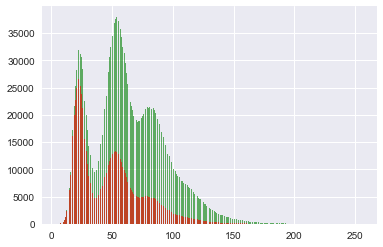

In [23]:

sns.set()
h, bins = np.histogram(tabund, bins = 'auto')
sns.distplot(tabund, bins=bins, color = "g", hist_kws = {'alpha' : 0.6}, kde = False, norm_hist = False)
sns.distplot(tabund, bins=bins, hist_kws={'weights' : eweight, 'alpha' : 0.6}, color = "r", kde = False, norm_hist=False)

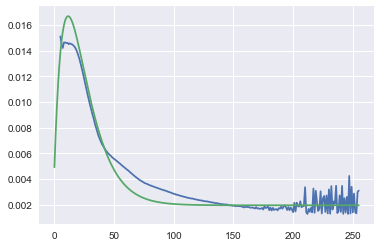

In [784]:
def nbparam(r,l):
    return r/(l+r)

pdist = p_actual/np.nansum(p_actual)
plt.plot(x, pdist)
j = 2
p_est = .5 * scipy.stats.uniform.pdf(x, scale = len(x)) + .5 * scipy.stats.nbinom.pmf(x, j, nbparam(j, first_lambda))
plt.plot(x, p_est)
# p_error = p_actual * tcounts / sum(tcounts)
# plt.plot(x, p_error)
# p_est * tcounts

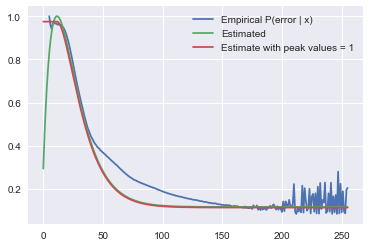

In [796]:
plt.plot(x, p_actual)
# plt.plot(x, pdist * np.nansum(ecounts / tcounts)) #== p_actual
plt.plot(x, p_est / max(p_est))
fitted = p_est/max(p_est) * .975
peak = int(first_lambda / j)
fixed = fitted
fixed[:peak] = .975
plt.plot(x, fixed)
plt.legend(labels=("Empirical P(error | x)","Estimated","Estimate with peak values = 1"))

0.38602841713484615


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


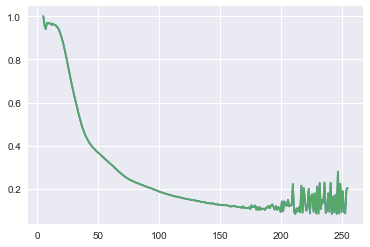

In [792]:
p_e_given_x = p_actual
p_x_given_e = ecounts/sum(ecounts)
p_error = sum(ecounts)/sum(tcounts)
p_x = tcounts/sum(tcounts)

print(p_error)

plt.plot(x, p_e_given_x)
plt.plot(x, p_x_given_e * p_error / p_x) #yes, they are the same.

# The rest of this notebook is just garbo

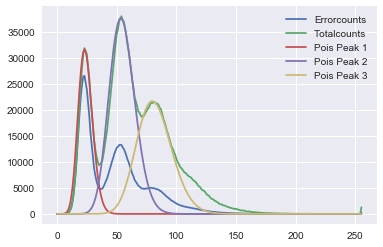

In [483]:
x = np.arange(len(tcounts))
plt.plot(x,ecounts)
plt.plot(x,tcounts)

lambda_ests = scipy.signal.argrelmax(tcounts)[0]
first_lambda = lambda_ests[0] + 1
second_lambda = lambda_ests[1] + 1
third_lambda = lambda_ests[4] + 1

def nbparam(r,l):
    return r/(l+r)
def normalize(x, dist, normalizer):
    return dist.pmf(x) / dist.pmf(np.floor(dist.mean())) * normalizer

first_pois = scipy.stats.poisson(mu = first_lambda)
second_pois = scipy.stats.poisson(mu = second_lambda)
third_pois = scipy.stats.poisson(mu = third_lambda)

first_factor = tcounts[first_lambda] / first_pois.pmf(np.floor(first_pois.mean()))
second_factor = tcounts[second_lambda] / second_pois.pmf(np.floor(second_pois.mean()))
third_factor = tcounts[third_lambda] / third_pois.pmf(np.floor(third_pois.mean()))

r = 50
s = 50
t = 50

first_nb = scipy.stats.nbinom(r,nbparam(r,first_lambda))
second_nb = scipy.stats.nbinom(s, nbparam(s,second_lambda))
third_nb = scipy.stats.nbinom(t, nbparam(t,third_lambda))

# first_est = first_pois.pmf(x) * tcounts[first_lambda] / first_pois.pmf(np.floor(first_pois.mean()))
# second_est = second_pois.pmf(x) * tcounts[second_lambda] / second_pois.pmf(np.floor(second_pois.mean()))
# third_est = third_pois.pmf(x) * tcounts[third_lambda] / third_pois.pmf(np.floor(third_pois.mean()))

first_est = first_nb.pmf(x) * tcounts[first_lambda] / first_nb.pmf(np.floor(first_nb.mean()))
second_est = second_nb.pmf(x) * tcounts[second_lambda] / second_nb.pmf(np.floor(second_nb.mean()))
third_est = third_nb.pmf(x) * tcounts[third_lambda] / third_nb.pmf(np.floor(third_nb.mean()))

plt.plot(x,first_est)
plt.plot(x,second_est)
plt.plot(x,third_est)
plt.legend(labels = ('Errorcounts','Totalcounts','Pois Peak 1','Pois Peak 2','Pois Peak 3', 'NB 1'));


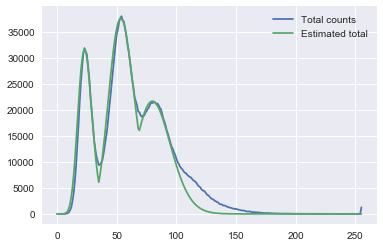

In [484]:
total_est = np.maximum(first_est, second_est)
total_est = np.maximum(total_est, third_est)

plt.plot(x, tcounts)
plt.plot(x,total_est)
plt.legend(labels = ('Total counts','Estimated total'));

 # The strategy
It seems the best way to fit this is:
  1. Fit a Poisson to the total abundance peaks to find:
      * a good normalization factor (n)
      * a good λ
  2. Fit a Negative Binomial to the total abundance peaks to find a good r parameter
      * Use the appropriate normalization factor (this will be different than n defined above)
      * If you want to fit the total abundance curve, use this distribution
      * Divide the normalization factor by the peak number (1, 2, 3, etc.) for reasons unknown
  3. Use the obtained r, n, and λ to fit a negative binomial.

This will be the distribution of erroneous kmers.

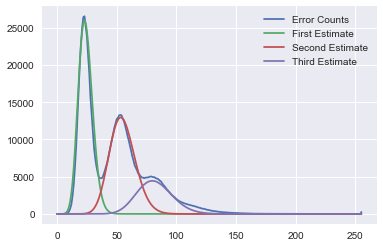

In [477]:
plt.plot(x, ecounts)

u = 50
v = 50
w = 50

first_err_est = scipy.stats.nbinom.pmf(x, u, nbparam(u, first_lambda)) * first_factor
second_err_est = scipy.stats.nbinom.pmf(x, v, nbparam(v, second_lambda)) * second_factor / 2
third_err_est = scipy.stats.nbinom.pmf(x, w, nbparam(w, third_lambda)) * third_factor / 3

plt.plot(x, first_err_est)
plt.plot(x, second_err_est)
plt.plot(x, third_err_est)
plt.legend(labels = ("Error Counts", "First Estimate", "Second Estimate", "Third Estimate"));

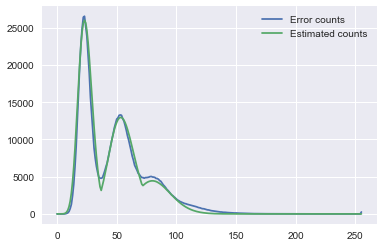

In [478]:
err_est = np.maximum(first_err_est, second_err_est)
err_est = np.maximum(err_est, third_err_est)

plt.plot(x, ecounts)
plt.plot(x, err_est)
plt.legend(labels = ('Error counts','Estimated counts'));

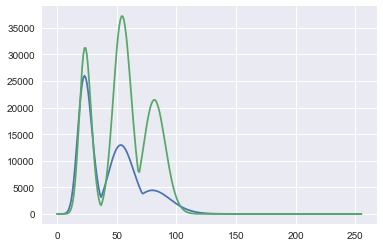

In [479]:
plt.plot(err_est)
plt.plot(total_est)


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


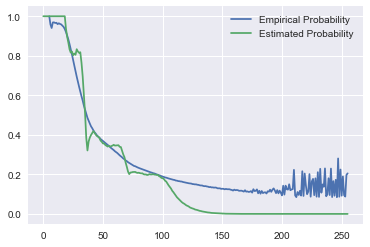

In [806]:
p_actual = ecounts / tcounts
p_est = err_est / tcounts

plt.plot(p_actual)
plt.plot(x, np.clip(p_est,0,1))
# plt.plot(x, scipy.stats.expon.pdf(x/first_lambda))
# plt.plot(x,scipy.stats.expon.pdf(x/second_lambda))
# plt.plot(x,scipy.stats.expon.pdf(x/third_lambda))
# plt.plot(x, 1/(1+np.exp((x-25)/25)))
plt.legend(labels=("Empirical Probability", "Estimated Probability"))


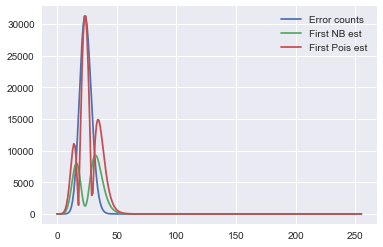

In [265]:
plt.plot(x, ecounts)
plt.plot(x, first_est)
plt.plot(x,first_pois_est)
plt.plot(x, first_d)

# first_err_count = tcounts[r] - np.average(x,weights=difference_p)
first_err_est = normalize(x, first_pois, first_err_count)
plt.plot(x, np.abs(difference_p) / np.abs(difference_p[r]) * tcounts[r])

# plt.plot(x, first_err_count)
plt.legend(labels = ("Error counts", "First NB est", "First Pois est", "Difference", "First Error est"));


# d_peaks = scipy.signal.argrelmax(d)[0]
# print(np.mean(d[d_peaks] - 2 * d[r]))
# print(np.average(d, weights=d))
# print(tcounts[r] - ecounts[r])
# print(first_pois_est[r] - ecounts[r])

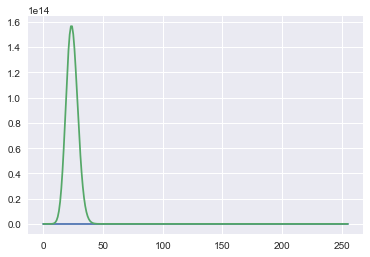

In [247]:
plt.figure()
plt.plot(x,ecounts)
plt.plot(x,first_err_est)
second_pois = scipy.stats.poisson(mu = s - 1)
second_pois_est = normalize(x, second_pois, tcounts[s])
second_d = second_est - second_pois_est
second_p = second_dist.pmf(x) - second_pois.pmf(x)
second_err_counts = np.average(second_d, weights=second_p)

# second_err_est = normalize(x, second_dist, second_err_counts)
# second_pois_est = normalize(x, second_pois, tcounts[s])
# plt.plot(second_est)
# plt.plot(second_err_counts)
# plt.plot(second_d)

# plt.legend(labels = ("Error counts", "First Err est", "Second Tot. Est.","Second Err Est.","Second Difference"));

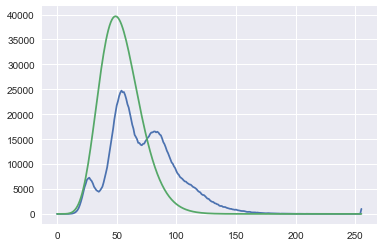

In [490]:
plt.plot(x,tcounts - ecounts)
t = 12
et = scipy.stats.nbinom(t, nbparam(t,tot_lambda))
est = normalize(x, et, tcounts[tot_lambda])
plt.plot(x,est)

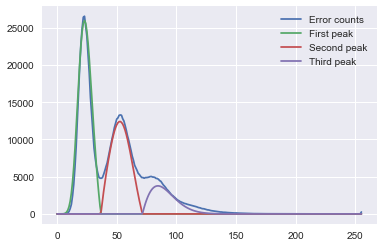

In [465]:
first_subtracted = np.clip(first_err_est - second_err_est - third_err_est, 0, None)
second_subtracted = np.clip(second_err_est - first_err_est - third_err_est, 0, None)
third_subtracted = np.clip(third_err_est - first_err_est - second_err_est, 0, None)

plt.plot(x, ecounts)
plt.plot(x, first_subtracted)
plt.plot(x, second_subtracted)
plt.plot(x, third_subtracted)
plt.legend(labels = ('Error counts','First peak','Second peak','Third peak'))

# Let's try to re-weight things to actually make sense as a mixture of distributions!

1.0000000000000135


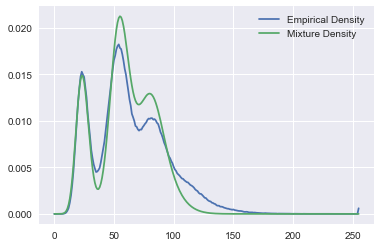

In [579]:
w_total = tcounts / sum(tcounts)
w_errors = ecounts / sum(ecounts)

dists = np.array([first_pois.pmf(x), first_nb.pmf(x), second_pois.pmf(x), second_nb.pmf(x), third_pois.pmf(x), third_nb.pmf(x)])
# w = np.repeat(1/len(dists), len(dists))
w = np.array([.1, .1, .3, .1, .1, .3])
tmixture = [w[i] * dists[i] for i in range(len(dists))]

print(sum(sum(tmixture)))
plt.plot(x, w_total)
plt.plot(x, sum(tmixture))
plt.legend(labels=("Empirical Density","Mixture Density", "Error Density"));


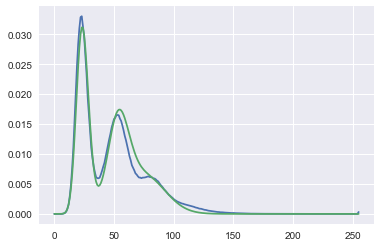

In [618]:
plt.plot(x, w_errors)

dists = np.array([first_pois.pmf(x), first_nb.pmf(x), second_pois.pmf(x), second_nb.pmf(x), third_pois.pmf(x), third_nb.pmf(x)])
# w = np.repeat(1/len(dists), len(dists))
w = np.array([.3, .1, .1, .3, 0, .2])
emixture = [w[i] * dists[i] for i in range(len(dists))]

plt.plot(x,sum(emixture));


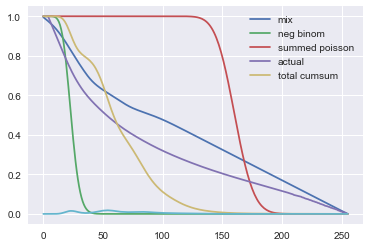

In [617]:
m = sum(emixture)/sum(tmixture)
m = m / sum(m)
plt.plot(x,1 - np.cumsum(m))
plt.plot(x,first_nb.sf(x))
plt.plot(x,scipy.stats.poisson.sf(x, mu = first_lambda + second_lambda + third_lambda))
plt.plot(1 - np.nancumsum(p_actual / np.nansum(p_actual)))
plt.plot(x, 1 - np.cumsum(tcounts/sum(tcounts)))
plt.plot(x, tcounts/sum(tcounts))
plt.legend(labels = ("mix","neg binom","summed poisson", "actual","total cumsum"));

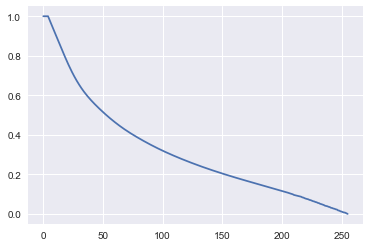

In [615]:
plt.plot(1 - np.nancumsum(p_actual / np.nansum(p_actual)))